# Reconocimiento de entidades nombradas

En este código se muestran los pasos para crear una red neuronal para reconocer entidades en los registros de la base de datos de Esposalles. También se puede aplicar a otros textos etiquetados. La tarea se divide fundamentalmente en dos partes, donde la primera hace referencia a la detección únicamente de las categorías semánticas y en la segunda se añade un poco más de dificultad al identificar adicionalmente la persona asociada, ambas a nivel de palabra. Además, en cada tarea se predicen las etiquetas para un conjunto de mejores hipótesis que han sido creadas por un grafo de palabras. Con estas predicciones y las etiquetas de los registros originales, se calculará la distancia o error entre ellas utilizando la distancia de Levenshtein para ver lo que se pierde entre ambas.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import re

El primer paso es leer los ficheros donde se ubican los registros matrimoniales y sus etiquetas, almacenandolos en sus respectivas listas. Debido a que los registros y etiquetas correspondientes se encuentran en la misma carpeta, las posiciones entre listas son consistentes entre sí.

In [2]:
records,person_labels,category_labels = [], [], []

rootdir = 'C:/Users/Jose Giner/OneDrive/Escritorio/TFG/JG-data'
filepath_records = []

for subdir, dirs, files in os.walk(rootdir):
    
    
    try:
        dirs.sort(key=lambda s:int(''.join(filter(str.isdigit,s[-2:]))))
        dirs.sort(key = lambda s:int(''.join(filter(str.isdigit,s[6:11])))) 
    
    except:
        pass
    
    
    for file in files:
        filepath = os.path.join(subdir, file)
        if filepath.endswith("transcription.txt") and "words" in filepath:
            with open(filepath) as f:
                filepath_records.append(filepath)
                lines = []
                for line in f:
                    line = line.rstrip()
                    partitioned_string = line.partition(':')
                    lines.append(partitioned_string[2])
            records.append(lines) 
        
        elif filepath.endswith("person.txt") and "words" in filepath:
            with open(filepath) as f:
                lines = []
                for line in f:
                    line = line.rstrip()
                    partitioned_string = line.partition(':')
                    lines.append(partitioned_string[2])
            person_labels.append(lines)
        
        elif filepath.endswith("category.txt") and "words" in filepath:
            with open(filepath) as f:
                lines = []
                for line in f:
                    line = line.rstrip()
                    partitioned_string = line.partition(':')
                    lines.append(partitioned_string[2])
            category_labels.append(lines)
            
        

In [5]:
print("Total registros: ",len(records))

Total registros:  968


Creamos un diccionario de frecuencias de palabras y mostramos las palabras más frecuentes.

In [3]:
dic_counts = {}
for r in records:
    for word in r:
        dic_counts[word] = 1+dic_counts.get(word,0)

dic_decr = dict(sorted(dic_counts.items(), key = lambda x: x[1], reverse = True))
c = 1
for k,v in dic_decr.items():
    if c <= 10:
        print('{}) {} : {}'.format(str(c),k,str(v)))
    else:
        break
    c += 1

1) de : 6355
2) y : 1338
3) pages : 977
4) ab : 966
5) rebere : 934
6) filla : 729
7) Bara : 718
8) donsella : 646
9) dia : 590
10) fill : 570


In [4]:
vocab_size = len(dic_counts.keys())
print("Tamaño del vocabulario:",vocab_size)

Tamaño del vocabulario: 2430


El vocabulario es muy reducido para una colección de 968 registros, significando que muchos de ellos emplean palabras similares. Ahora se ilustra la distribución Zipf de frecuencias.

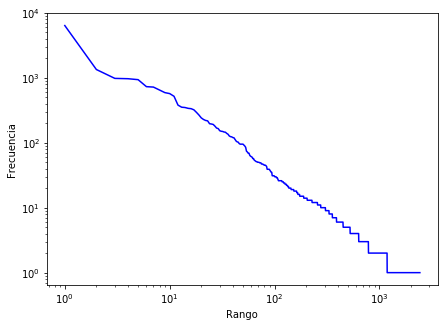

In [8]:
rf = [(r+1, freq) for r, freq in enumerate(dic_decr.values())]
rs, fs = zip(*rf)

plt.figure(figsize = (7,5))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Rango')
plt.ylabel('Frecuencia')
plt.plot(rs, fs, 'b-')
plt.show()

Se sigue la norma donde la frecuencia de cada término es inversamente proporcional a su rango o posición que ocupan en el diccionario. Abajo se muestra con un dataframe más información sobre la distribución.

In [8]:
import pandas as pd
from numpy.random import randint

data = []
c = 1
tot_pal = len([w for r in records for w in r])
for pal,freq in dic_decr.items():
    data.append([pal, c, freq, freq/tot_pal, c * freq])
    c += 1

df = pd.DataFrame(data,columns=['Término', 'Rank', 'Frecuencia','Proporción','Rank*Frecuencia'])
df

,Término,Rank,Frecuencia,Proporción,Rank*Frecuencia
0,de,1,6355,0.201740,6355
1,y,2,1338,0.042475,2676
2,pages,3,977,0.031015,2931
3,ab,4,966,0.030666,3864
4,rebere,5,934,0.029650,4670
5,filla,6,729,0.023142,4374
6,Bara,7,718,0.022793,5026
7,donsella,8,646,0.020507,5168
8,dia,9,590,0.018730,5310
9,fill,10,570,0.018095,5700


Realizamos el mismo proceso para las etiquetas de persona y categoría semántica.

In [5]:
person_counts = {}
for r in person_labels:
    for etiqueta in r:
        person_counts[etiqueta] = 1+person_counts.get(etiqueta,0)

dict(sorted(person_counts.items(), key = lambda x: x[1], reverse = True))

{'none': 15176,
 'husband': 5827,
 'wifes_father': 3592,
 'wife': 2771,
 'husbands_father': 2314,
 'wifes_mother': 754,
 'husbands_mother': 602,
 'other_person': 465}

In [6]:
category_counts = {}
for r in category_labels:
    for etiqueta in r:
        category_counts[etiqueta] = 1+category_counts.get(etiqueta,0)

dict(sorted(category_counts.items(), key = lambda x: x[1], reverse = True))

{'other': 15176,
 'name': 4997,
 'location': 4509,
 'occupation': 3010,
 'surname': 2667,
 'state': 1142}

Mostramos las palabras más frecuentes por categoría semántica

In [9]:
name_freq = {}
surname_freq = {}
loc_freq = {}
occ_freq = {}
state_freq = {}

for r1,r2 in zip(records,category_labels):
    for w,lab in zip(r1,r2):
        if lab == 'name':
            name_freq[w] = 1 + name_freq.get(w,0)
        
        elif lab == 'surname':
            surname_freq[w] = 1 + surname_freq.get(w,0)
        
        elif lab == 'location':
            loc_freq[w] = 1 + loc_freq.get(w,0)

        elif lab == 'occupation':
            occ_freq[w] = 1 + occ_freq.get(w,0)
        
        elif lab == 'state':
            state_freq[w] = 1 + state_freq.get(w,0)

name_freq = dict(sorted(name_freq.items(), key = lambda x: x[1], reverse = True)[:8])       
surname_freq = dict(sorted(surname_freq.items(), key = lambda x: x[1], reverse = True)[:8])  
loc_freq = dict(sorted(loc_freq.items(), key = lambda x: x[1], reverse = True)[:8])       
occ_freq = dict(sorted(occ_freq.items(), key = lambda x: x[1], reverse = True)[:8])  
state_freq = dict(sorted(state_freq.items(), key = lambda x: x[1], reverse = True)[:8])  


df_name = pd.DataFrame(name_freq.items(), columns=['Name', 'Frequency'])
df_surname = pd.DataFrame(surname_freq.items(), columns=['Surname', 'Frequency'])
df_loc = pd.DataFrame(loc_freq.items(), columns=['Location', 'Frequency'])
df_occ = pd.DataFrame(occ_freq.items(), columns=['Occupation', 'Frequency'])
df_state = pd.DataFrame(state_freq.items(), columns=['State', 'Frequency'])


result = pd.concat([df_name, df_surname, df_loc, df_occ, df_state], axis=1)
result
        

,Name,Frequency,Surname,Frequency,Location,Frequency,Occupation,Frequency,State,Frequency
0,Pere,308,de,48,Bara,717,pages,972,donsella,640
1,Juan,216,Soler,27,de,641,de,249,viuda,223
2,t,193,font,24,St,230,parayre,217,viudo,194
3,Antoni,191,Marti,24,bisbat,145,sastre,94,dosella,68
4,Elisabeth,180,Puig,23,dita,144,texidor,88,sella,8
5,Jua,163,Serra,22,regne,137,sabater,62,don,4
6,Margarida,151,ferrer,20,franÃ§a,118,mestre,57,do,4
7,jaume,145,Vidal,19,parrochia,90,llana,52,donzella,1


Creamos otro diccionario para almacenar las frecuencias por carácter.

In [10]:
dic_counts_char = {}

for r in records:
    for word in r:
        for char in word:
            dic_counts_char[char] = 1+dic_counts_char.get(char,0)

dict(sorted(dic_counts_char.items(), key = lambda x: x[1], reverse = True)[:10])

{'e': 20382,
 'a': 20035,
 'd': 11374,
 'r': 10971,
 'l': 9208,
 'i': 8173,
 'n': 7585,
 't': 6591,
 's': 6059,
 'o': 4867}

### 1) NER solo con categorías semánticas

En este primer experimento solo se consideran las etiquetas de categorías semánticas. Por tanto, asociamos a cada palabra de cada registro su respectiva categoria y vemos como queda un registro etiquetado.

In [11]:
tagged_records = []
for r1,r2 in zip(records, category_labels):
    record = []
    for w,category in zip(r1,r2):
        record.append((w,category))
    tagged_records.append(record)

print(tagged_records[198],'\n')  

[('dit', 'other'), ('dia', 'other'), ('rebere', 'other'), ('de', 'other'), ('Antoni', 'name'), ('fetjo', 'surname'), ('parayre', 'occupation'), ('de', 'other'), ('St', 'location'), ('Cugat', 'location'), ('de', 'location'), ('Vallers', 'location'), ('fill', 'other'), ('de', 'other'), ('Jua', 'name'), ('fetjo', 'surname'), ('pages', 'occupation'), ('y', 'other'), ('de', 'other'), ('Eularia', 'name'), ('defuncts', 'other'), ('ab', 'other'), ('Violant', 'name'), ('viuda', 'other'), ('de', 'other'), ('Jua', 'name'), ('Moner', 'surname'), ('boter', 'occupation'), ('de', 'other'), ('dita', 'location'), ('vila', 'location')] 



Comprobamos la distribucion de longitudes de registros para hacernos una idea de cuantas palabras contienen.

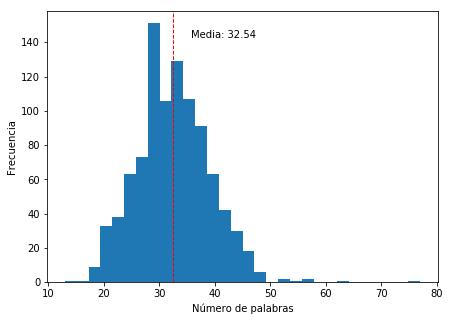

In [13]:
plt.figure(figsize = (7,5))
x = [len(r) for r in tagged_records]
plt.hist(x, bins = 30)
plt.axvline(np.mean(x), color='r', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(np.mean(x)*1.1, max_ylim*0.9, 'Media: {:.2f}'.format(np.mean(x)))
plt.xlabel('Número de palabras')
plt.ylabel('Frecuencia')
plt.show()

Parece existen algunos registros más largos de lo habitual, aunque estos son casos extremos.

Algunos estadísticos de interés:

In [14]:
print('Mínimo :',min(x))
print('Máximo :',max(x))
print('Media :', round(np.mean(x),2))
print('Desviación :', round(np.std(x),2))

Mínimo : 13
Máximo : 77
Media : 32.54
Desviación : 6.69


Mismo proceso para las longitudes de palabras en base a la cantidad caracteres que la forman.

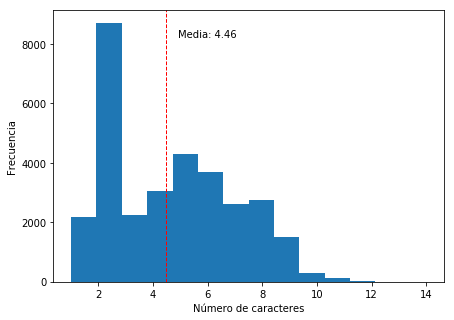

In [15]:
plt.figure(figsize = (7,5))
x = [len(w[0]) for r in tagged_records for w in r]
plt.hist(x, bins = 14)
plt.axvline(np.mean(x), color='r', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(np.mean(x)*1.1, max_ylim*0.9, 'Media: {:.2f}'.format(np.mean(x)))
plt.xlabel('Número de caracteres')
plt.ylabel('Frecuencia')
plt.show()

In [11]:
print('Mínimo :',min(x))
print('Máximo :',max(x))
print('Media :', round(np.mean(x),2))
print('Desviación :', round(np.std(x),2))

Mínimo : 1
Máximo : 14
Media : 4.46
Desviación : 2.47


Con ayuda de las distribuciones de longitudes de registros y palabras vistas, hay que definir las longitudes de secuencias para ser entradas a la red neuronal. En caso de los registros parece que son pocos los que tienen más de 50 palabras por lo que se elige esta longitud como tamaño máximo de la secuencia de palabras, y las palabras se fijan a 10 caracteres. La información a nivel de carácter también es importante puesto que da pistas al modelo sobre la estructura interna de palabras desconocidas. Debido a que las redes neuronales trabajan con datos numéricos, se han de establecer correspondencias entre índices y cada palabra, carácter y etiqueta para luego obtener unas predicciones.

In [12]:
max_len = 50
max_len_char = 10

vocab = list(dic_counts.keys())
vocab_chars = list(dic_counts_char.keys())
tags = list(category_counts.keys())

n_words = len(vocab)
n_chars = len(vocab_chars)
n_tags = len(tags)

word2idx = {w: i for i, w in enumerate(vocab,1)}
char2index = {c:i for i,c in enumerate(vocab_chars,1)}
tag2idx = {t: i for i, t in enumerate(tags)}

A continuación, codificamos las palabras de los registros en base a las correspondencias creadas y fijamos la longitud máxima para todos los registros para que tengan el mismo tamaño y puedan ser tomados posteriormente por el modelo. Si un registro no alcanza dicha longitud, se completa añadiendo ceros, técnica conocida como 'padding'.

In [13]:
from keras.preprocessing.sequence import pad_sequences

X_word = [[word2idx[w[0]] for w in r] for r in tagged_records]
X_word = pad_sequences(maxlen=max_len, sequences= X_word, padding="post", value=0)
X_word[8]

array([104,  48, 105,   9,   4,  60, 106, 107,   4, 108,   4, 109,  16,
         4,  31, 106, 110,   7,   4,  28,  75,  21,  22,  23,  24,   4,
        31, 111,  18,   4,  67,  89,   7,   4,  22,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

Se sigue el mismo procedimiento para codificar los caracteres de cada palabra en cada registro. Aquí tenemos múltiples matrices por cada registro donde se tienen tantas filas como tamaño de la secuencia de registros se haya definido y tantas columnas como tamaño de la secuencia de caracteres definida, en este caso 10.

In [15]:
X_char = []
for r in tagged_records:
    rec_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2index.get(r[i][0][j]))
            except:
                word_seq.append(0)
        rec_seq.append(word_seq)
    X_char.append(np.array(rec_seq))

X_char[8]

array([[28,  9, 42,  3, 18, 11,  0,  0,  0,  0],
       [ 4,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [44,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 2,  8, 15,  8,  2,  8,  0,  0,  0,  0],
       [ 7,  8,  0,  0,  0,  0,  0,  0,  0,  0],
       [34,  9, 27, 18,  8,  5,  0,  0,  0,  0],
       [21,  3, 12,  4,  2,  0,  0,  0,  0,  0],
       [12,  4,  2,  9, 14,  8,  2,  0,  0,  0],
       [ 7,  8,  0,  0,  0,  0,  0,  0,  0,  0],
       [23,  9,  5,  4, 14,  3, 33,  4,  0,  0],
       [ 7,  8,  0,  0,  0,  0,  0,  0,  0,  0],
       [17, 18, 15,  8,  5,  5,  4, 11,  0,  0],
       [20,  9,  5,  5,  0,  0,  0,  0,  0,  0],
       [ 7,  8,  0,  0,  0,  0,  0,  0,  0,  0],
       [29, 18,  4,  0,  0,  0,  0,  0,  0,  0],
       [21,  3, 12,  4,  2,  0,  0,  0,  0,  0],
       [ 6,  8, 11, 31,  4,  7,  3,  2,  0,  0],
       [13,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 7,  8,  0,  0,  0,  0,  0,  0,  0,  0],
       [26, 18,  5,  4,  2,  9,  4,  0,  0,  0],
       [ 7,  8, 20, 

Codificamos las etiquetas con sus índices asociados. El relleno se hace con el índice 0 de la categoría 'other' aunque en este caso no es relevante.

In [16]:
y = [[tag2idx[w[1]] for w in r] for r in tagged_records]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["other"])
y[8]

array([0, 0, 0, 0, 0, 1, 2, 3, 0, 4, 4, 4, 0, 0, 1, 2, 3, 0, 0, 1, 0, 0,
       1, 5, 0, 0, 1, 2, 3, 0, 4, 4, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

Con las entradas y etiquetas codificadas, el siguiente paso es definir grupos de particiones de entrenamiento y validación para ser utilizadas por el modelo NER posteriormente. 

In [17]:
from sklearn.model_selection import train_test_split

X_word_tr, X_word_te, y_tr, y_te = train_test_split(X_word, y, test_size=0.2, random_state=2021)
X_char_tr, X_char_te, _, _ = train_test_split(X_char, y, test_size=0.2, random_state=2021)

Puesto que los índices 0 de palabras inexistentes no queremos que se tengan en cuenta por el modelo a la hora de extraer sus predicciones, se define una función para agrupar las predicciones e incluso etiquetas de los términos reales. Esto es importante para que los resultados finales de clasificación no consideren estos índices.  

In [18]:
idx2tag = {i:w for w, i in tag2idx.items()}

def number_2_label_unmasked(pred,x,dic_lab):
    out = []
    record_count = 0
    for pred_i in pred:
        out_i = []
        word_count = 0
        for p in pred_i:
            if x[record_count][word_count] != 0: 
                out_i.append(dic_lab[p])
                word_count += 1
        out.append(out_i)
        record_count += 1
    return out

Importamos todas los modulos y funciones necesarias para la creación del modelo

In [19]:
import tensorflow as tf
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D
import keras.optimizers 
from tf_crf_layer.layer import CRF
from tf_crf_layer.loss import crf_loss, ConditionalRandomFieldLoss
from tf_crf_layer.metrics import crf_accuracy
from tf_crf_layer.metrics.sequence_span_accuracy import SequenceSpanAccuracy
from tensorflow.keras.callbacks import ModelCheckpoint

Entrenamos el modelo con validación cruzada. En cada iteración se ha de definir un nuevo modelo para entrenarlo y validarlo con diferentes particiones. 

In [17]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score

# 5 folds
n_folds = 5

acc_per_fold = []
f1_per_fold = []

#Se concatenan las particiones creadas anteriormente (luego se emplearán para las mejores hipótesis)
word_inputs = np.concatenate((X_word_tr, X_word_te), axis=0)
char_inputs = np.concatenate((X_char_tr, X_char_te), axis=0)
targets = np.concatenate((y_tr, y_te), axis=0)

kfold = KFold(n_splits=n_folds, shuffle=True)

fold_no = 1
for train, test in kfold.split(word_inputs, char_inputs,targets):
    
    #DEFINICIÓN DE LA RED NEURONAL 
    
    #Se toman las secuencias de palabras como primera entrada y se aprenden sus embeddings o representaciones distribuidas
    word_in = Input(shape=(max_len,))
    emb_word = Embedding(input_dim=n_words + 2, output_dim=20,
                         input_length=max_len, mask_zero=True,  name='word_embeddings')(word_in)

    #Se toman las matrices de caracteres de palabras como segunda entrada y se aprenden los embeddings
    char_in = Input(shape=(max_len, max_len_char,))
    emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=10,
                               input_length=max_len_char, mask_zero=True, name='char_embeddings'))(char_in)
    
    # LSTM a nivel de carácter para codificar las palabras
    char_enc = TimeDistributed(LSTM(units=20, return_sequences=False,
                                    recurrent_dropout=0.3, name='char_LSTM'))(emb_char)

    # Codifiador de contexto tomando las embeddings de palabras y las representaciones de sus caracteres.
    x = concatenate([emb_word, char_enc])
    x = SpatialDropout1D(0.3)(x)    #Dropout para reducir sobreajuste 
    
    main_lstm = Bidirectional(LSTM(units=50, return_sequences=True,
                                   recurrent_dropout=0.3, name='bi-lstm'))(x)
    #out = TimeDistributed(Dense(n_tags, activation="softmax"))(main_lstm)

    #Capa CRF para decodificar las etiquetas
    out = CRF(n_tags, name="crf_layer")(main_lstm)


    model = Model([word_in, char_in], out)

    #Función de pérdida, optimizador y métrica a monitorizar
    crf_loss_instance = ConditionalRandomFieldLoss() 
    optimizer = tf.keras.optimizers.Adam(0.01)
    model.compile(optimizer=optimizer, loss={"crf_layer": crf_loss_instance}, metrics=[SequenceSpanAccuracy()])


    
    #ENTRENAMIENTO DEL MODELO 
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    history = model.fit([word_inputs[train],
                        char_inputs[train].reshape((len(char_inputs[train]), max_len, max_len_char))], 
                      targets[train].reshape(len(targets[train]), max_len, 1),
                      batch_size=32,
                      epochs= 30,
                      validation_data= ([word_inputs[test],
                                char_inputs[test].reshape((len(char_inputs[test]), max_len, max_len_char))], 
                                targets[test].reshape(len(targets[test]), max_len, 1)),
                      verbose=1)

    #Predicciones del modelo con la partición de validación
    pred = model.predict([word_inputs[test], 
                         char_inputs[test].reshape((len(char_inputs[test]),
                                                     max_len, max_len_char))])
    
    
    #Se combinan todas las predicciones en cada fold
    if fold_no != 1:
        total_records = np.concatenate((total_records,word_inputs[test]), axis = 0)
        total_preds = np.concatenate((total_preds,pred), axis = 0)
        total_labels = np.concatenate((total_labels,targets[test]), axis = 0)
    
    else:
        total_records = word_inputs[test]
        total_preds = pred
        total_labels = targets[test]
        
    #Ignoramos las predicciones y etiquetas de las palabras de relleno
    pred_labels = number_2_label_unmasked(pred,word_inputs[test],idx2tag)
    test_labels = number_2_label_unmasked(targets[test],word_inputs[test],idx2tag)

    
    pred_list = [p for p_i in pred_labels for p in p_i]
    test_list = [p for p_i in test_labels for p in p_i]

    #Medimos la accuracy y f1 final. Los almacenamos para luego hacer un promedio
    acc = accuracy_score(test_list,pred_list)
    f1 = f1_score(test_list,pred_list, average = 'macro')
    print(f'Score for fold {fold_no}: Accuracy of {round(acc,4) * 100}%; F1 score of {round(f1,3)}')
    acc_per_fold.append(round(acc,4) * 100)
    f1_per_fold.append(round(f1,3))
    
    fold_no = fold_no + 1
    
    
#RESULTADOS FINALES   
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Accuracy: {acc_per_fold[i]}% - F1 score: {f1_per_fold[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)}% (+- {round(np.std(acc_per_fold),3)})')
print(f'> F1: {np.mean(f1_per_fold)}')
print('------------------------------------------------------------------------')

    

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/30
<tf_crf_layer.layer.CRF object at 0x0000016B91293B70> 0
<tf_crf_layer.layer.CRF object at 0x0000016B91293B70> 0
25/25 [==============================] - 11s 139ms/step - loss: 29.1679 - sequence_span_accuracy: 0.6307 - val_loss: 20.2266 - val_sequence_span_accuracy: 0.6667
Epoch 2/30
25/25 [==============================] - 3s 106ms/step - loss: 7.9482 - sequence_span_accuracy: 0.7332 - val_loss: 2.4087 - val_sequence_span_accuracy: 0.7971
Epoch 3/30
25/25 [==============================] - 3s 108ms/step - loss: 1.9145 - sequence_span_accuracy: 0.8341 - val_loss: 1.8312 - val_sequence_span_accuracy: 0.8614
Epoch 4/30
25/25 [==============================] - 3s 101ms/step - loss: 1.2245 - sequence_span_accuracy: 0.8798 - val_loss: 1.4236 - val_sequence_span_accuracy: 0.8944
Epoch 5/30
2

Epoch 13/30
25/25 [==============================] - 2s 92ms/step - loss: 0.2854 - sequence_span_accuracy: 0.9597 - val_loss: 1.9585 - val_sequence_span_accuracy: 0.9611
Epoch 14/30
25/25 [==============================] - 3s 102ms/step - loss: 0.3002 - sequence_span_accuracy: 0.9624 - val_loss: 2.0588 - val_sequence_span_accuracy: 0.9635
Epoch 15/30
25/25 [==============================] - 2s 99ms/step - loss: 0.2928 - sequence_span_accuracy: 0.9646 - val_loss: 2.0798 - val_sequence_span_accuracy: 0.9656
Epoch 16/30
25/25 [==============================] - 2s 98ms/step - loss: 0.2529 - sequence_span_accuracy: 0.9666 - val_loss: 1.9770 - val_sequence_span_accuracy: 0.9675
Epoch 17/30
25/25 [==============================] - 2s 94ms/step - loss: 0.2456 - sequence_span_accuracy: 0.9684 - val_loss: 2.0245 - val_sequence_span_accuracy: 0.9692
Epoch 18/30
25/25 [==============================] - 2s 91ms/step - loss: 0.2431 - sequence_span_accuracy: 0.9699 - val_loss: 2.0353 - val_sequence_s

25/25 [==============================] - 3s 131ms/step - loss: 0.3828 - sequence_span_accuracy: 0.9650 - val_loss: 1.3874 - val_sequence_span_accuracy: 0.9663
Epoch 12/30
25/25 [==============================] - 3s 131ms/step - loss: 0.3595 - sequence_span_accuracy: 0.9676 - val_loss: 1.4062 - val_sequence_span_accuracy: 0.9688
Epoch 13/30
25/25 [==============================] - 4s 144ms/step - loss: 0.3315 - sequence_span_accuracy: 0.9699 - val_loss: 1.5614 - val_sequence_span_accuracy: 0.9708
Epoch 14/30
25/25 [==============================] - 4s 142ms/step - loss: 0.2967 - sequence_span_accuracy: 0.9718 - val_loss: 1.3743 - val_sequence_span_accuracy: 0.9726
Epoch 15/30
25/25 [==============================] - 3s 134ms/step - loss: 0.2781 - sequence_span_accuracy: 0.9734 - val_loss: 1.4145 - val_sequence_span_accuracy: 0.9742
Epoch 16/30
25/25 [==============================] - 3s 131ms/step - loss: 0.3187 - sequence_span_accuracy: 0.9749 - val_loss: 1.5051 - val_sequence_span_acc

Con todas las predicciones reunidas de cada registro, mostramos los resultados con las métricas del informe de clasificación de `sklearn`. 

In [19]:
from sklearn.metrics import classification_report

idx2tag = {i:w for w, i in tag2idx.items()}

pred_labels = number_2_label_unmasked(total_preds, total_records, idx2tag)
test_labels = number_2_label_unmasked(total_labels, total_records, idx2tag)

pred_list = [p for p_i in pred_labels for p in p_i]
test_list = [p for p_i in test_labels for p in p_i]

print(classification_report(test_list,pred_list, digits = 3))

              precision    recall  f1-score   support

    location     0.9580    0.9676    0.9628      4507
        name     0.9905    0.9856    0.9881      4992
  occupation     0.9877    0.9584    0.9728      3008
       other     0.9842    0.9868    0.9855     15132
       state     0.9709    0.9939    0.9823      1142
     surname     0.9639    0.9642    0.9641      2657

    accuracy                         0.9795     31438
   macro avg     0.9759    0.9761    0.9759     31438
weighted avg     0.9796    0.9795    0.9795     31438



Creamos el mismo modelo para predecir las etiquetas en las mejores hipótesis.

In [20]:
# embeddings de palabras
word_in = Input(shape=(max_len,))
emb_word = Embedding(input_dim=n_words + 2, output_dim=20,
                     input_length=max_len, mask_zero=True,  name='word_embeddings')(word_in)

# embeddings de caracteres
char_in = Input(shape=(max_len, max_len_char,))
emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=10,
                           input_length=max_len_char, mask_zero=True, name='char_embeddings'))(char_in)

# LSTM que codifica caracteres de palabras
char_enc = TimeDistributed(LSTM(units=20, return_sequences=False,
                                recurrent_dropout=0.3))(emb_char)

# Bi-LSTM - codificador de contexto
x = concatenate([emb_word, char_enc])
x = SpatialDropout1D(0.3)(x)
main_lstm = Bidirectional(LSTM(units=50, return_sequences=True,
                               recurrent_dropout=0.3))(x)
#out = TimeDistributed(Dense(n_tags, activation="softmax"))(main_lstm)

#Capa CRF para decodificar las etiquetas
out = CRF(n_tags, name="crf_layer")(main_lstm)


model = Model([word_in, char_in], out)

crf_loss_instance = ConditionalRandomFieldLoss() 
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(optimizer=optimizer, loss={"crf_layer": crf_loss_instance}, metrics=[SequenceSpanAccuracy()])

model.summary()

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 50, 10)]     0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 time_distributed (TimeDistribu  (None, 50, 10, 10)  620         ['input_2[0][0]']                
 ted)                                                                                             
                                                                                                 

Las particiones originales de entrenamiento y test se utilizan para esta ocasión y se ilustra la evolución en el aprendizaje en la función de pérdida y tasa de acierto. El entrenamiento se divide en un conjunto de validación del 20%. Importante recordar que no se están evaluando todavía las mejores hipótesis. Esto es simplemente para comprobar como se comporta el modelo con los registros originales.

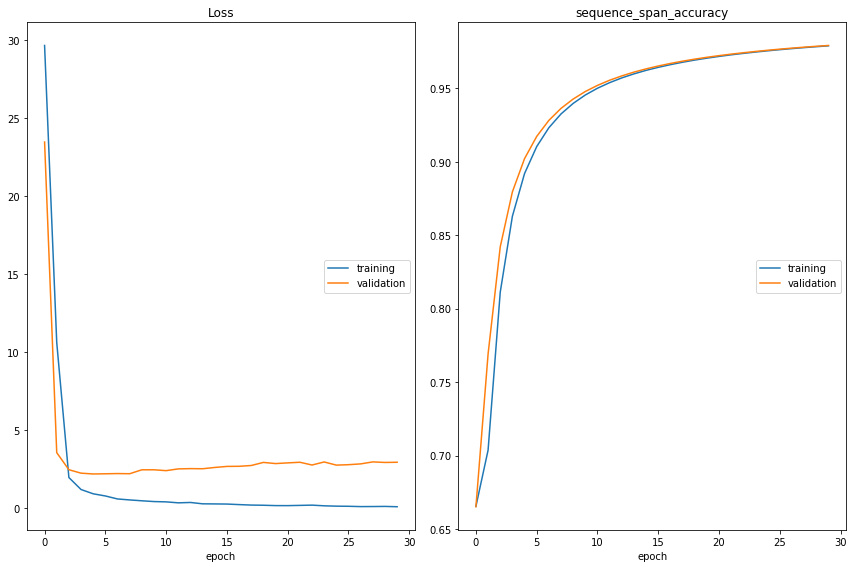

Loss
	training         	 (min:    0.092, max:   29.672, cur:    0.092)
	validation       	 (min:    2.193, max:   23.480, cur:    2.944)
sequence_span_accuracy
	training         	 (min:    0.665, max:    0.979, cur:    0.979)
	validation       	 (min:    0.665, max:    0.979, cur:    0.979)
20/20 [==============================] - 2s 103ms/step - loss: 0.0918 - sequence_span_accuracy: 0.9789 - val_loss: 2.9440 - val_sequence_span_accuracy: 0.9792


In [21]:
from livelossplot.tf_keras import PlotLossesCallback
from tensorflow.keras.callbacks import ModelCheckpoint

plot_loss_1 = PlotLossesCallback()


model.fit([X_word_tr,
                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
                    np.array(y_tr).reshape(len(y_tr), max_len, 1),
                    batch_size=32, epochs=30, validation_split=0.2 ,callbacks=[plot_loss_1],verbose=1)

Se mide su rendimiento en el conjunto de test.

In [25]:
y_pred = model.predict([X_word_te,
                        np.array(X_char_te).reshape((len(X_char_te),
                                                     max_len, max_len_char))])

In [26]:
from sklearn.metrics import classification_report

idx2tag = {i:w for w, i in tag2idx.items()}



pred_labels = number_2_label_unmasked(y_pred, X_word_te, idx2tag)
test_labels = number_2_label_unmasked(y_te, X_word_te, idx2tag)

pred_list = [p for p_i in pred_labels for p in p_i]
test_list = [p for p_i in test_labels for p in p_i]

print(classification_report(test_list,pred_list, digits = 3))

              precision    recall  f1-score   support

    location      0.953     0.964     0.958       921
        name      0.995     0.985     0.990      1012
  occupation      0.982     0.979     0.980       606
       other      0.986     0.983     0.985      3071
       state      0.982     0.978     0.980       227
     surname      0.961     0.981     0.971       521

    accuracy                          0.980      6358
   macro avg      0.976     0.978     0.977      6358
weighted avg      0.980     0.980     0.980      6358



Los resultados son parecidos a los de la validación cruzada pero estos son representan a un 20% del total de registros. Mostramos un ejemplo de predicción de etiquetas para un registro aleatorio del conjunto de test junto a las etiquetas reales.

In [36]:
import random

idx2word = {i:w for w,i in word2idx.items()}
i = random.randint(0,len(y_pred))


print("{:15}||{:15}||{}".format("Word", "True", "Pred"))
print(70 * "=")
for w, t, pred in zip(X_word_te[i], y_te[i], y_pred[i]):
    if w != 0:
        print("{:15}: {:15} {}".format(idx2word[w], idx2tag[t], idx2tag[pred]))

Word           ||True           ||Pred
Dimecres       : other           other
a              : other           other
31             : other           other
rebere         : other           other
de             : other           other
Miquel         : name            name
Galcera        : surname         surname
pages          : occupation      occupation
de             : other           other
Aulesa         : location        location
de             : location        location
Montse         : location        location
rat            : location        location
fill           : other           other
de             : other           other
Antich         : name            name
Galcera        : surname         surname
pages          : occupation      occupation
y              : other           other
de             : other           other
Margarida      : name            name
defuncts       : other           other
ab             : other           other
Margarida      : name            name
don

### NER con las 1-best o mejores hipótesis generadas por cada registro

Ahora se leen las mejores hipótesis ubicadas en un fichero independiente al de los registros originales. Para seleccionar las transcripciones coincidentes con los registros originales, se guardan los números de páginas. 

In [24]:
pags_true_records = set()
for r in filepath_records:
    m = re.search('idPage(\d+)', r)
    pags_true_records.add(m.group(1))

In [25]:
unobest_file = 'C:\\Users\\Jose Giner\\OneDrive\\Escritorio\\TFG\\Esposalles-1-b\\Esposalles-best_hypothesis.txt'

with open(unobest_file) as f:
    best_rec = []
    for line in f:
        line = line.split()
        pagina = int(line[0][-6:-3])
        if str(pagina + 10353) in pags_true_records:
            best_rec.append(line[1:])


Comprobamos que se tiene la misma cantidad de registros. 

In [26]:
len(best_rec) == len(records)

True

Seleccionamos un registro aleatorio y su mejor hipótesis para ver cómo difieren.

In [30]:
print("     {:22}{:22}{}".format("Mejor hipótesis", "Registro original", "Etiqueta"))
print(70 * "-")

rec = records[747]

et = [w[1] for w in tagged_records[747]]
for j in range(len(rec),len(best_rec[747])):
    rec.append('')
    et.append('')
  
c = 1
for w1,w2,e in list(zip(rec,best_rec[747],et)):
    print('{:3}) {:22}{:22}{}'.format(c,w2,w1,e))
    c += 1


     Mejor hipótesis       Registro original     Etiqueta
----------------------------------------------------------------------
  1) Dit                   Dit                   other
  2) dia                   dia                   other
  3) rebere$               rebere                other
  4) de                    de                    other
  5) Pau                   Pau                   name
  6) Riba                  Ribafort              surname
  7) font                  sabater               occupation
  8) sabater               de                    other
  9) de                    Palau                 location
 10) Palau                 solitar               location
 11) solitar               viudo                 state
 12) viudo                 ab                    other
 13) ab                    Catherina             name
 14) Catherina             viuda                 state
 15) viuda                 de                    other
 16) de                    Agusti  

Vemos que existe un problema con términos que están mal separados y que por tanto desplazan de posición a las siguientes palabras. Esto es un problema puesto que las etiquetas ya no refieren a los términos correspondientes (por ejemplo la palabra 'ab' tiene asociada la etiqueta 'name' como consecuencia en vez de 'other'). Dicho esto, las etiquetas reales no pueden ser utilizadas para evaluar las predicciones por posición. Sin embargo, sí que se puede determinar la similitud entre las etiquetas reales y las predichas utilizando la [distancia de Levenshtein](https://es.wikipedia.org/wiki/Distancia_de_Levenshtein).

Codificamos las palabras de las mejores hipótesis de la misma forma que antes pero la diferencia es que no todos los términos están definidos en el vocabulario del diccionario `word2idx`. Ante esta situación se genera otro índice adicional para representar a palabras desconocidas.

In [27]:
X_best_word = [[word2idx[token] if token in word2idx else n_words+1 for token in r] for r in best_rec]
X_best_word = pad_sequences(maxlen=max_len, sequences= X_best_word, padding="post", value=0)
X_best_word[0]

array([  48, 2431, 1819,   18,    4,   29, 2431,    7, 1685, 1037,    4,
         10, 2431,    4,   12,   13,   14,    4, 2431,   16,    4, 1744,
         13,   18,    4,   19,    7,    4,   20, 2431,   21,   22,   23,
         24,    4,   74, 1394, 2051, 1208,    4, 2431,   16,    4,   40,
         16,    4, 2431, 2431,    0,    0])

Lo mismo se aplica para los caracteres, donde los desconocidos se codifícan con un índice especial.

In [28]:
X_best_char = []
for r in best_rec:
    rec_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2index[r[i][j]])
            except IndexError:
                word_seq.append(0)
            
            except KeyError:
                word_seq.append(n_chars + 1)
                
        rec_seq.append(word_seq)
    X_best_char.append(np.array(rec_seq))



X_best_char[10]

array([[28,  9, 10,  0,  0,  0,  0,  0,  0,  0],
       [ 7,  9,  4,  0,  0,  0,  0,  0,  0,  0],
       [ 2,  8, 15,  8,  2,  8, 61,  0,  0,  0],
       [ 7,  8,  0,  0,  0,  0,  0,  0,  0,  0],
       [34,  4, 10, 32,  8, 18,  0,  0,  0,  0],
       [21,  4, 11, 11,  4,  0,  0,  0,  0,  0],
       [12,  3,  5,  9, 14,  8,  2,  0,  0,  0],
       [ 7,  8,  0,  0,  0,  0,  0,  0,  0,  0],
       [20,  8,  2,  2,  8, 10,  0,  0,  0,  0],
       [32,  4, 15,  9, 10,  4, 61, 10,  0,  0],
       [ 8, 14,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 5,  4,  0,  0,  0,  0,  0,  0,  0,  0],
       [38,  3, 31, 32,  4,  0,  0,  0,  0,  0],
       [ 4, 15,  0,  0,  0,  0,  0,  0,  0,  0],
       [34,  4,  2, 22,  4,  2,  9,  7,  4,  0],
       [ 7,  3, 61, 11,  8,  5,  5,  4,  0,  0],
       [20,  9,  5,  5,  4,  0,  0,  0,  0,  0],
       [ 7,  8,  0,  0,  0,  0,  0,  0,  0,  0],
       [28,  4, 12,  9,  4,  0,  0,  0,  0,  0],
       [17,  4,  5,  6,  0,  0,  0,  0,  0,  0],
       [ 6,  4,  2, 

Con las entradas preprocesadas, ya se utiliza el modelo anterior entrenado con los registros auténticos para evaluar las predicciones.

In [29]:
y_pred_best = model.predict([X_best_word,
                        np.array(X_best_char).reshape((len(X_best_char),
                                                     max_len, max_len_char))])

Ahora se calcula la distancia de Levenshtein promedia entre las sequencias reales de etiquetas y las predichas.

In [30]:
import textdistance

pred_labels = number_2_label_unmasked(y_pred_best, X_best_word, idx2tag)
test_labels = number_2_label_unmasked(y, X_word, idx2tag)
dist = []
for pred_i,true_i in zip(pred_labels,test_labels):
    d = textdistance.levenshtein.distance(list(pred_i),list(true_i))

    dist.append(d)

np.mean(dist)

3.6549586776859506

La distancia media es cercana a 4 indicando que las secuencias necesitan en promedio 4 operaciones de edición para ser idénticas. Las operaciones incluyen borrados, inserciones y sustituciones, con un coste asociado.

Si se muestran las predicciones sobre transcripciones al azar, estas encajan bastante con las palabra correspondientes. Destacar que las palabras desconocidas por el modelo se han representado como `UNK`.

In [82]:
import random

idx2word = {i:w for w,i in word2idx.items()}
i = random.randint(0,len(y_pred_best))


print("{:15}||{}".format("Word", "Pred"))
print(45 * "=")
for w, pred in zip(X_best_word[i], y_pred_best[i]):
    if w == n_words + 1:
        print("{:15}: {}".format("UNK",idx2tag[pred]))
    elif w != 0:
        print("{:15}: {} ".format(idx2word[w],idx2tag[pred]))
       

Word           ||Pred
Dissapte       : other 
a              : other 
UNK            : other
23             : other 
UNK            : other
de             : other 
Antoni         : name 
Moner          : surname 
pages          : occupation 
de             : other 
Dorrius        : location 
viudo          : state 
ab             : other 
Ca             : name 
Margarida      : name 
viuda          : state 
de             : other 
UNK            : name
Crich          : surname 
pages          : occupation 
de             : other 
Canoves        : location 
UNK            : location


### 2) NER con categorias semánticas y personas

En la segunda parte de la experimentación se consideran además de las categorías semánticas, las personas relacionadas en cada palabra, significando que se tienen que concatenar para formar las etiquetas finales.

In [31]:
person_category_counts = {}
for r1, r2 in zip(person_labels, category_labels):
    for e1, e2 in zip(r1, r2):
        new_label = e1 + "-" + e2
        person_category_counts[new_label] = 1+person_category_counts.get(new_label,0)

person_category_counts = dict(sorted(person_category_counts.items(), key = lambda x: x[1], reverse = True))

In [32]:
person_category_counts

{'none-other': 15176,
 'husband-location': 2374,
 'husband-occupation': 1207,
 'wifes_father-location': 1170,
 'wife-name': 1046,
 'husband-name': 1025,
 'husband-surname': 1010,
 'wife-state': 931,
 'wifes_father-occupation': 893,
 'wifes_father-surname': 769,
 'wifes_father-name': 760,
 'wifes_mother-name': 737,
 'husbands_father-occupation': 640,
 'husbands_father-name': 618,
 'husbands_father-surname': 586,
 'husbands_mother-name': 582,
 'wife-location': 490,
 'husbands_father-location': 470,
 'wife-occupation': 270,
 'other_person-surname': 235,
 'other_person-name': 229,
 'husband-state': 211,
 'wife-surname': 34,
 'wifes_mother-surname': 17,
 'husbands_mother-surname': 16,
 'husbands_mother-location': 4,
 'other_person-location': 1}

Se asocian estas nuevas etiquetas a cada palabra de cada registro y se ilustra un ejemplo de representación.

In [41]:
tagged_records = []
for r1,r2,r3 in zip(records, person_labels, category_labels):
    record = []
    for w,person,category in zip(r1,r2,r3):
        new_label = person + "-" + category
        record.append((w,new_label))
    tagged_records.append(record)

print(tagged_records[370],'\n')  

[('dit', 'none-other'), ('dia', 'none-other'), ('rebere', 'none-other'), ('de', 'none-other'), ('Pere', 'husband-name'), ('Bassons', 'husband-surname'), ('pages', 'husband-occupation'), ('de', 'none-other'), ('Cervello', 'husband-location'), ('fill', 'none-other'), ('de', 'none-other'), ('Jua', 'husbands_father-name'), ('Bassos', 'husbands_father-surname'), ('pages', 'husbands_father-occupation'), ('defunct', 'none-other'), ('y', 'none-other'), ('de', 'none-other'), ('Antonia', 'husbands_mother-name'), ('ab', 'none-other'), ('Madrona', 'wife-name'), ('donsella', 'wife-state'), ('filla', 'none-other'), ('de', 'none-other'), ('Pere', 'wifes_father-name'), ('Alegre', 'wifes_father-surname'), ('pages', 'wifes_father-occupation'), ('de', 'none-other'), ('Castellvi', 'wifes_father-location'), ('y', 'none-other'), ('de', 'none-other'), ('Juana', 'wifes_mother-name')] 



Modificamos las correspondencias entre etiquetas e índices.

In [48]:
tags = list(person_category_counts.keys())
n_tags = len(tags)
tag2idx = {t:i for i,t in enumerate(tags)}
idx2tag = {i:w for w, i in tag2idx.items()}

y = [[tag2idx[w[1]] for w in r] for r in tagged_records]
y = pad_sequences(maxlen = max_len, sequences = y, padding = 'post' , value = tag2idx['none-other'])
y[370]

array([ 0,  0,  0,  0,  5,  6,  2,  0,  1,  0,  0, 13, 14, 12,  0,  0,  0,
       15,  0,  4,  7,  0,  0, 10,  9,  8,  0,  3,  0,  0, 11,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

De nuevo, definimos otras particiones a considerar.

In [43]:
X_word_tr, X_word_te, y_tr, y_te = train_test_split(X_word, y, test_size=0.2, random_state=2021)
X_char_tr, X_char_te, _, _ = train_test_split(X_char, y, test_size=0.2, random_state=2021)

Aplicamos validación cruzada para predecir las etiquetas de todos los registros

In [374]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score

n_folds = 5

acc_per_fold = []
f1_per_fold = []


word_inputs = np.concatenate((X_word_tr, X_word_te), axis=0)
char_inputs = np.concatenate((X_char_tr, X_char_te), axis=0)
targets = np.concatenate((y_tr, y_te), axis=0)

kfold = KFold(n_splits=n_folds, shuffle=True)

fold_no = 1
for train, test in kfold.split(word_inputs, char_inputs,targets):
    
    word_in = Input(shape=(max_len,))
    emb_word = Embedding(input_dim=n_words + 2, output_dim=20,
                         input_length=max_len, mask_zero=True,  name='word_embeddings')(word_in)


    char_in = Input(shape=(max_len, max_len_char,))
    emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=10,
                               input_length=max_len_char, mask_zero=True, name='char_embeddings'))(char_in)

    
    char_enc = TimeDistributed(LSTM(units=20, return_sequences=False,
                                    recurrent_dropout=0.3, name='char_LSTM'))(emb_char)

    x = concatenate([emb_word, char_enc])
    x = SpatialDropout1D(0.3)(x)
    main_lstm = Bidirectional(LSTM(units=50, return_sequences=True,
                                   recurrent_dropout=0.3, name='bi-lstm'))(x)
    #out = TimeDistributed(Dense(n_tags, activation="softmax"))(main_lstm)

    out = CRF(n_tags, name="crf_layer")(main_lstm)


    model = Model([word_in, char_in], out)

    crf_loss_instance = ConditionalRandomFieldLoss() 
    optimizer = tf.keras.optimizers.Adam(0.01)
    model.compile(optimizer=optimizer, loss={"crf_layer": crf_loss_instance}, metrics=[SequenceSpanAccuracy()])


    

    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    history = model.fit([word_inputs[train],
                        char_inputs[train].reshape((len(char_inputs[train]), max_len, max_len_char))], 
                      targets[train].reshape(len(targets[train]), max_len, 1),
                      batch_size=32,
                      epochs= 30,
                      validation_data= ([word_inputs[test],
                                char_inputs[test].reshape((len(char_inputs[test]), max_len, max_len_char))], 
                                targets[test].reshape(len(targets[test]), max_len, 1)),
                      verbose=1)

    
    pred = model.predict([word_inputs[test], 
                         char_inputs[test].reshape((len(char_inputs[test]),
                                                     max_len, max_len_char))])
    
    
    if fold_no != 1:
        total_records = np.concatenate((total_records,word_inputs[test]), axis = 0)
        total_preds = np.concatenate((total_preds,pred), axis = 0)
        total_labels = np.concatenate((total_labels,targets[test]), axis = 0)
    
    else:
        total_records = word_inputs[test]
        total_preds = pred
        total_labels = targets[test]
        
    pred_labels = number_2_label_unmasked(pred,word_inputs[test],idx2tag)
        
        
    test_labels = number_2_label_unmasked(targets[test],word_inputs[test],idx2tag)

    
    
    pred_list = [p for p_i in pred_labels for p in p_i]
    test_list = [p for p_i in test_labels for p in p_i]

    acc = accuracy_score(test_list,pred_list)
    f1 = f1_score(test_list,pred_list, average = 'macro')
    print(f'Score for fold {fold_no}: Accuracy of {round(acc,4) * 100}%; F1 score of {round(f1,3)}')
    acc_per_fold.append(round(acc,4) * 100)
    f1_per_fold.append(round(f1,3))
    
    fold_no = fold_no + 1
    
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Accuracy: {acc_per_fold[i]}% - F1 score: {f1_per_fold[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)}% (+- {round(np.std(acc_per_fold),3)})')
print(f'> F1: {np.mean(f1_per_fold)}')
print('------------------------------------------------------------------------')


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/30
<tf_crf_layer.layer.CRF object at 0x000001AEC7C8E7B8> 0
<tf_crf_layer.layer.CRF object at 0x000001AEC7C8E7B8> 0
25/25 [==============================] - 11s 141ms/step - loss: 45.3411 - sequence_span_accuracy: 0.6106 - val_loss: 33.3006 - val_sequence_span_accuracy: 0.6439
Epoch 2/30
25/25 [==============================] - 3s 101ms/step - loss: 22.6466 - sequence_span_accuracy: 0.6658 - val_loss: 9.7017 - val_sequence_span_accuracy: 0.7163
Epoch 3/30
25/25 [==============================] - 3s 105ms/step - loss: 6.8347 - sequence_span_accuracy: 0.7603 - val_loss: 3.6429 - val_sequence_span_accuracy: 0.7957
Epoch 4/30
25/25 [==============================] - 3s 114ms/step - loss: 3.2634 - sequence_span_accuracy: 0.8207 - val_loss: 2.4998 - val_sequence_span_accuracy: 0.8414
Epoch 5/30
25/25 [==============================] - 3s 110ms/step - loss: 2.1626 - sequence_span_accuracy: 

25/25 [==============================] - 3s 104ms/step - loss: 0.2461 - sequence_span_accuracy: 0.9725 - val_loss: 2.6078 - val_sequence_span_accuracy: 0.9729
Epoch 30/30
25/25 [==============================] - 3s 103ms/step - loss: 0.2110 - sequence_span_accuracy: 0.9733 - val_loss: 2.5868 - val_sequence_span_accuracy: 0.9737
Score for fold 3: Accuracy of 97.58%; F1 score of 0.901
------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/30
<tf_crf_layer.layer.CRF object at 0x000001AEC6E93A20> 0
<tf_crf_layer.layer.CRF object at 0x000001AEC6E93A20> 0
25/25 [==============================] - 12s 157ms/step - loss: 44.8711 - sequence_span_accuracy: 0.5703 - val_loss: 32.5442 - val_sequence_span_accuracy: 0.6287
Epoch 2/30
25/25 [==============================] - 3s 115ms/step - loss: 22.4210 - sequence_span_accuracy: 0.6583 - val_loss: 8.7510 - val_sequence_span_accuracy: 0.7149
Epoch 3/30
25/25 [==============================] - 3s 114ms/

Obtenemos los resultados individuales por etiqueta y globales.

In [378]:
pred_labels = number_2_label_unmasked(total_preds, total_records, idx2tag)
test_labels = number_2_label_unmasked(total_labels, total_records, idx2tag)

pred_list = [p for p_i in pred_labels for p in p_i]
test_list = [p for p_i in test_labels for p in p_i]

print(classification_report(test_list,pred_list, digits = 4, zero_division = True))

                            precision    recall  f1-score   support

          husband-location     0.9677    0.9730    0.9704      2372
              husband-name     0.9882    0.9843    0.9863      1021
        husband-occupation     0.9837    0.9535    0.9684      1205
             husband-state     0.9747    0.9147    0.9438       211
           husband-surname     0.9703    0.9761    0.9732      1004
  husbands_father-location     0.9146    0.9574    0.9356       470
      husbands_father-name     0.9837    0.9789    0.9813       617
husbands_father-occupation     0.9856    0.9609    0.9731       640
   husbands_father-surname     0.9429    0.9639    0.9533       582
  husbands_mother-location     1.0000    0.0000    0.0000         4
      husbands_mother-name     0.9812    0.9845    0.9828       582
   husbands_mother-surname     0.2222    0.1250    0.1600        16
                none-other     0.9866    0.9857    0.9861     15132
     other_person-location     1.0000    0.0000

Creamos el mismo modelo para predecir las mejores hipótesis

In [36]:
#embeddings de palabras
word_in = Input(shape=(max_len,))
emb_word = Embedding(input_dim=n_words + 2, output_dim=20,
                     input_length=max_len, mask_zero=True)(word_in)

#embeddings de caracteres
char_in = Input(shape=(max_len, max_len_char,))
emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=10,
                           input_length=max_len_char, mask_zero=True))(char_in)

# Codificación de caracteres de palabras
char_enc = TimeDistributed(LSTM(units=20, return_sequences=False,
                                recurrent_dropout=0.5))(emb_char)

# Bi-LSTM para codificar el contexto
x = concatenate([emb_word, char_enc])
x = SpatialDropout1D(0.3)(x)
main_lstm = Bidirectional(LSTM(units=50, return_sequences=True,
                               recurrent_dropout=0.6))(x)

#CRF para decodificar las etiquetas
out = CRF(n_tags, name="crf_layer")(main_lstm)


model = Model([word_in, char_in], out)

crf_loss_instance = ConditionalRandomFieldLoss() 
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(optimizer=optimizer, loss={"crf_layer": crf_loss_instance}, metrics=[SequenceSpanAccuracy()])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 50, 10)]     0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 time_distributed_2 (TimeDistri  (None, 50, 10, 10)  620         ['input_4[0][0]']                
 buted)                                                                                           
                                                                                                  
 embedding (Embedding)          (None, 50, 20)       48640       ['input_3[0][0]']          

Monitorizamos su entrenamiento

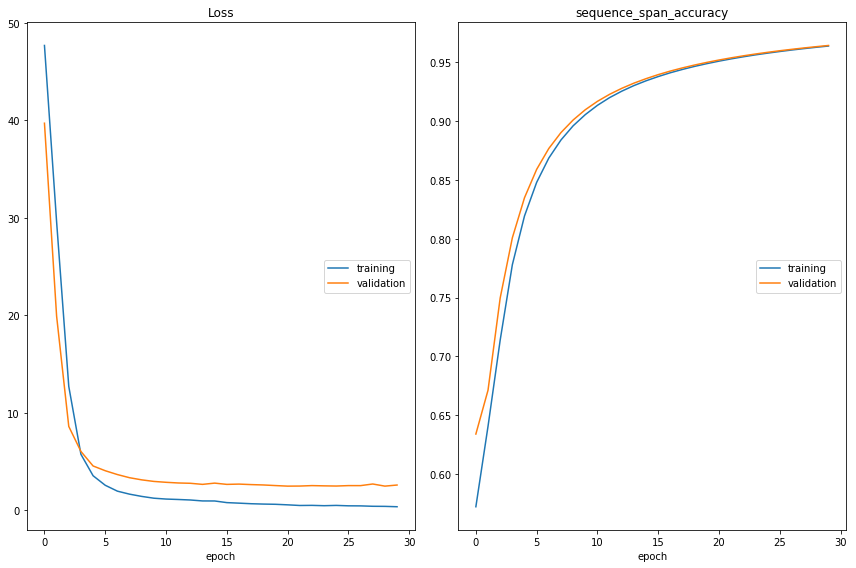

Loss
	training         	 (min:    0.366, max:   47.673, cur:    0.366)
	validation       	 (min:    2.479, max:   39.700, cur:    2.592)
sequence_span_accuracy
	training         	 (min:    0.572, max:    0.964, cur:    0.964)
	validation       	 (min:    0.634, max:    0.964, cur:    0.964)
20/20 [==============================] - 2s 117ms/step - loss: 0.3658 - sequence_span_accuracy: 0.9639 - val_loss: 2.5921 - val_sequence_span_accuracy: 0.9644


In [37]:
from livelossplot.tf_keras import PlotLossesCallback
from tensorflow.keras.callbacks import ModelCheckpoint

plot_loss_2 = PlotLossesCallback()


model.fit([X_word_tr,
                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
                    np.array(y_tr).reshape(len(y_tr), max_len, 1),
                    batch_size=32, epochs=30, validation_split=0.2 ,callbacks=[plot_loss_2],verbose=1)

El modelo es evaluado sobre el conjunto de test (todavía con los registros originales).

In [44]:
y_pred = model.predict([X_word_te,
                        np.array(X_char_te).reshape((len(X_char_te),
                                                     max_len, max_len_char))])

Mostramos cómo son las predicciones sobre un registro aleatorio.

In [324]:
i = random.randint(0,len(y_pred))

print("{:15}||{:35}||{}".format("Word", "True", "Pred"))
print(70 * "=")
for w, t, pred in zip(X_word_te[i], y_te[i], y_pred[i]):
    if w != 0:
        print("{:15}: {:35} {}".format(idx2word[w], idx2tag[t], idx2tag[pred]))

Word           ||True                               ||Pred
Diumege        : none-other                          none-other
a              : none-other                          none-other
3              : none-other                          none-other
rebere         : none-other                          none-other
del            : none-other                          none-other
Sr             : none-other                          none-other
Luys           : husband-name                        husband-name
Altarriba      : husband-surname                     husband-surname
mercader       : husband-occupation                  husband-occupation
de             : none-other                          none-other
Bara           : husband-location                    husband-location
fill           : none-other                          none-other
de             : none-other                          none-other
Juan           : husbands_father-name                husbands_father-name
Altarriba     

Ahora se extráen las predicciones sobre las mejores hipótesis y se extre la distancia media de Levenshtein con respecto a las etiquetas auténticas.

In [45]:
y_pred_best = model.predict([X_best_word,
                        np.array(X_best_char).reshape((len(X_best_char),
                                                     max_len, max_len_char))])

In [49]:
import textdistance

pred_labels = number_2_label_unmasked(y_pred_best, X_best_word, idx2tag)
test_labels = number_2_label_unmasked(y, X_word, idx2tag)
dist = []
for pred_i,true_i in zip(pred_labels,test_labels):
    d = textdistance.levenshtein.distance(list(pred_i),list(true_i))

    dist.append(d)

print('Distancia de edición media :',np.mean(dist))

Distancia de edición media : 3.9132231404958677


Finalmente, mostramos las predicciones sobre dos registros aleatorios.

In [255]:
import random

idx2word = {i:w for w,i in word2idx.items()}
i = random.randint(0,len(y_pred_best))
j = random.randint(0,len(y_pred_best))

if len(best_rec[i]) > len(best_rec[j]):
    rec1 = best_rec[i]
    rec2 = best_rec[j]
    pred1 = list(y_pred_best[i])
    pred2 = list(y_pred_best[j])
    
else:
    rec1 = best_rec[j]
    rec2 = best_rec[i]

    pred1 = list(y_pred_best[j])
    pred2 = list(y_pred_best[i])

for k in range(len(rec2),len(rec1)):
    rec2.append('')
    pred2[k] = ''


print("{:15}| {:30} {:15}| {}".format("Palabra", "Predición", "Palabra", "Predición"))
print(90 * "=")
for w1, p1, w2, p2 in zip(rec1, pred1, rec2, pred2):
    try:
        print("{:15}: {:30} {:15}: {}".format(w1,idx2tag[p1],w2,idx2tag[p2]))
    except KeyError:
        print("{:15}: {:30} ".format(w1,idx2tag[p1]))


Palabra        | Predición                      Palabra        | Predición
dit            : none-other                     Dit            : none-other
dia            : none-other                     dia            : none-other
rebere$        : none-other                     donare$        : husband-name
de             : none-other                     llicentia      : none-other
Gelida         : husband-name                   Juan           : husband-name
Elies          : husband-surname                Mas            : husband-surname
texidor        : husband-occupation             manya          : husband-occupation
de             : husband-occupation             habitant       : none-other
lli            : husband-occupation             en             : none-other
del            : none-other                     Bar^(a).       : husband-location
regne          : husband-location               fill           : none-other
de             : husband-location               de             : n

A pesar de existir palabras que son desconocidas por el modelo por no estar presentes en los registros auténticos, generalmente las salidas parecen acordar bastante. 